# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
%matplotlib inline 

#Import packages we need
import numpy as np
from matplotlib import animation, rc, cm
from matplotlib import pyplot as plt

import pycuda.compiler as cuda_compiler
import pycuda.driver as cuda_driver
from pycuda.gpuarray import GPUArray

import IPythonMagic
from Timer import Timer

In [2]:
%setup_logging
%cuda_context_handler context

Python version 3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 09:53:17) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Registering context in user workspace
Creating context
PyCUDA version 2018.1.1
CUDA version (8, 0, 0)
Driver version 9010
Using 'Quadro K2000' GPU
 => compute capability: (3, 0)
 => memory: 1877 / 1999 MB available
Created context handle <23686608>
Using CUDA cache dir /home/jobic/test/cuda/milan2018/MilanoGPU2018/notebooks/cuda_cache


# Heat equation in 2D
The heat equation can be written
$$
\begin{align}
\frac{\partial u}{\partial t} &= \kappa \nabla^2 u\\
&=\kappa \left[ \frac{\partial^2 u}{\partial x^2} +  \frac{\partial^2 u}{\partial y^2} \right]
\end{align}
$$
where $u$ is the temperature, and $\kappa$ is the material specific heat conduction constant. 

By approximating the temporal derivative with a backward difference, and the spatial derivative with a central difference, we get
$$
\frac{1}{\Delta t} (u_{i, j}^{n+1} - u_{i, j}^{n}) 
= \kappa \left [
\frac{1}{\Delta x^2}(u_{i-1, j}^n - 2u_{i, j}^n + u_{i+1, j}^n)
+ \frac{1}{\Delta y^2}(u_{i, j-1}^n - 2u_{i, j}^n + u_{i, j+1}^n)
\right]
$$
and gathering $u^n+1$ on the left hand side and $u^n$on the right, we write
$$
u^{n+1}_{i,j} = u_{i,j}^n 
+ \frac{\kappa\Delta t}{\Delta x^2}(u_{i-1, j}^n - 2u_{i, j}^n + u_{i+1, j}^n)
+ \frac{\kappa\Delta t}{\Delta y^2}(u_{i, j-1}^n - 2u_{i, j}^n + u_{i, j+1}^n)
$$
This discretization is unstable if the following CFL condition is not met
$$
\frac{1}{2} \gt \frac{\kappa\Delta t}{\Delta x^2}, \qquad
\frac{1}{2} \gt \frac{\kappa\Delta t}{\Delta y^2}
$$
or 
$$
\Delta t \lt \text{min}\left(\frac{\Delta x^2}{2\kappa}, \frac{\Delta y^2}{2\kappa}\right)
$$# Linear Wave Equation in 2D
The acoustic wave equation in 2D can be written
$$
\begin{align}
\frac{\partial^2 u}{\partial t^2} &= c^2 \nabla^2 u\\
&= c^2 \left[ \frac{\partial^2 u}{\partial x^2} +  \frac{\partial^2 u}{\partial y^2} \right]
\end{align}
$$
where $u$ is the string position, and c is a material specific constant. 

By approximating the temporal derivative with a backward difference, and the spatial derivative with a central difference, we get
$$
\frac{1}{\Delta t^2} (u_{i, j}^{n+1} - 2u_{i, j}^{n} + u_{i, j}^{n-1}) 
= c \left [
\frac{1}{\Delta x^2}(u_{i-1, j}^n - 2u_{i, j}^n + u_{i+1, j}^n)
+ \frac{1}{\Delta y^2}(u_{i, j-1}^n - 2u_{i, j}^n + u_{i, j+1}^n)
\right]
$$
and gathering $u^n+1$ on the left hand side and $u^n$on the right, we write
$$
u^{n+1}_{i,j} = 2u_{i,j}^n - u_{i, j}^{n-1}
+ \frac{\kappa\Delta t^2}{\Delta x^2}(u_{i-1, j}^n - 2u_{i, j}^n + u_{i+1, j}^n)
+ \frac{\kappa\Delta t^2}{\Delta y^2}(u_{i, j-1}^n - 2u_{i, j}^n + u_{i, j+1}^n)
$$
This discretization is unstable if the following CFL condition is not met
$$
\frac{1}{2} \gt \frac{\kappa\Delta t}{\Delta x^2}, \qquad
\frac{1}{2} \gt \frac{\kappa\Delta t}{\Delta y^2}
$$
or 
$$
\Delta t \lt \text{min}\left(\frac{\Delta x^2}{2\kappa}, \frac{\Delta y^2}{2\kappa}\right)
$$

In [3]:
class HeatEquationGPU(object):
    def __init__(self):
        pass
        
    def initialize(self, u0, kappa, dx, dy, dt, block_width=8, block_height=8):
        self.kappa = np.float32(kappa)
        self.dx = np.float32(dx)
        self.dy = np.float32(dy)
        self.dt = np.float32(dt)
        self.nx = np.int32(u0.shape[1]-2)
        self.ny = np.int32(u0.shape[0]-2)
        
        self.block_size = (block_width, block_height, 1)
        self.grid_size = (int(np.ceil(self.nx / block_width)), int(np.ceil(self.ny / block_height)), 1)
        self.stream = cuda_driver.Stream()
        
        self.u1_g = GPUArray(u0.shape, u0.dtype)
        self.u0_g = GPUArray(u0.shape, u0.dtype)
        
        self.u0_g.set_async(u0, stream=self.stream)
        
        
        cuda_kernel = \
        """
        #define BLOCK_WIDTH {:d}
        #define BLOCK_HEIGHT {:d}
        """.format(block_width, block_height) \
        + \
        """
        __global__ void heatEqn(float* u1, const float* u0, float kappa, float dx, float dy, float dt, int nx, int ny) {
            //Plus one to skip the "ghost cells"
            int i = blockIdx.x*blockDim.x + threadIdx.x + 1;
            int j = blockIdx.y*blockDim.y + threadIdx.y + 1;
            int tx = threadIdx.x + 1;
            int ty = threadIdx.y + 1;

            //First read into shared memory, including the local ghost cells / apron
            __shared__ float u0_shared[BLOCK_HEIGHT+2][BLOCK_WIDTH+2];
            for (int l=threadIdx.y; l<BLOCK_HEIGHT+2; l += blockDim.y) {
                int t = min(blockIdx.y*blockDim.y + l, ny);
                for (int k=threadIdx.x; k<BLOCK_WIDTH+2; k += blockDim.x) {
                    int s = min(blockIdx.x*blockDim.x + k, nx);
                    u0_shared[l][k] = u0[t*(nx+2) + s];
                }
            }
            __syncthreads();

            //Then fix the boundary conditions
            if (i == 1) {
                u0_shared[ty][tx-1] = u0_shared[ty][tx];
            }
            else if (i == nx) {
                u0_shared[ty][tx+1] = u0_shared[ty][tx];
            }
            else if (j == 1) {
                u0_shared[ty-1][tx] = u0_shared[ty][tx];
            }
            else if (j == ny) {
                u0_shared[ty+1][tx] = u0_shared[ty][tx];
            }
            __syncthreads();

            if (i >= 1 && i <= nx && j >= 1 && j <= ny) {
                u1[j*(nx+2) + i] = u0_shared[ty][tx]
                    + kappa*dt/(dx*dx) * (u0_shared[ty][tx-1] - 2.0f*u0_shared[ty][tx] + u0_shared[ty][tx+1])
                    + kappa*dt/(dy*dy) * (u0_shared[ty-1][tx] - 2.0f*u0_shared[ty][tx] + u0_shared[ty+1][tx]);
            }
        }
        """
        self.module = cuda_compiler.SourceModule(cuda_kernel, \
                                            options=['--use_fast_math'])
        self.heat_eqn_kernel = self.module.get_function("heatEqn");
        self.heat_eqn_kernel.prepare("PPffffii")
        
        
        
    def step(self):
        self.heat_eqn_kernel.prepared_async_call(self.grid_size, self.block_size, self.stream, \
                                                    self.u1_g.gpudata, self.u0_g.gpudata, \
                                                    self.kappa, self.dx, self.dy, self.dt, self.nx, self.ny)
        self.u0_g, self.u1_g = self.u1_g, self.u0_g
    
    
    def download(self):
        #self.u2 = cuda_driver.pagelocked_empty(u1.shape, u1.dtype)
        u0 = np.empty(self.u0_g.shape, self.u0_g.dtype)
        self.u0_g.get(u0)
        return u0


In [4]:
#Create test input data
kappa = 1.0
nx, ny = 100, 50
dx = 1.0
dy = 2.0
dt = 0.4*min(dx**2 / (2.0*kappa), dy**2 / (2.0*kappa))

u0 = np.zeros((ny, nx), dtype=np.float32)
for j in range(ny):
    for i in range(nx):
        x = (i - nx/2.0) * dx
        y = (j - ny/2.0) * dy
        if (np.sqrt(x**2 + y**2) < 10*min(dx, dy)):
            u0[j, i] = 10.0

with Timer("Initialization") as t:
    simulator = HeatEquationGPU()
    simulator.initialize(u0, kappa, dx, dy, dt)

Initialization: 348.536968 ms


locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fcb530b74a8>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fcb530b74a8>
Setting pcolormesh


update_title_pos
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/jobic/anaconda3/envs/gpudev/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


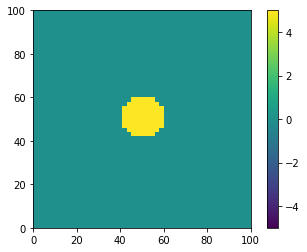

In [6]:
#Init
domain_extent = [0, nx*dx, 0, ny*dy]
im = plt.imshow(u0, origin='bottom', interpolation='none', vmin=-5, vmax=5, extent=domain_extent)
plt.colorbar()

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fcb52df3da0>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fcb52df3da0>
Setting pcolormesh


update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


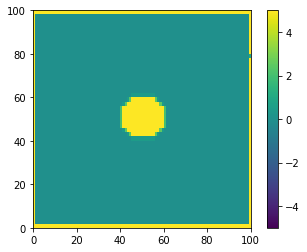

In [7]:
#Une iteration
simulator.step()
u1 = simulator.download()
domain_extent = [0, nx*dx, 0, ny*dy]
im = plt.imshow(u1, origin='bottom', interpolation='none', vmin=-5, vmax=5, extent=domain_extent)
plt.colorbar()

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fcb52d8fd68>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fcb52d8fd68>
Setting pcolormesh


update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


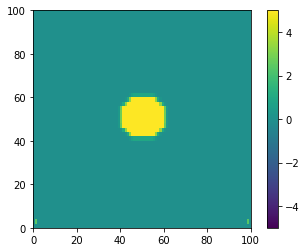

In [8]:
#Une deuxieme iteration
simulator.step()
u1 = simulator.download()
domain_extent = [0, nx*dx, 0, ny*dy]
im = plt.imshow(u1, origin='bottom', interpolation='none', vmin=-5, vmax=5, extent=domain_extent)
plt.colorbar()

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fcb52ca2b00>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fcb52ca2b00>
Setting pcolormesh


update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


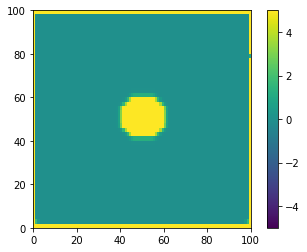

In [9]:
#Une 3 iteration
simulator.step()
u1 = simulator.download()
domain_extent = [0, nx*dx, 0, ny*dy]
im = plt.imshow(u1, origin='bottom', interpolation='none', vmin=-5, vmax=5, extent=domain_extent)
plt.colorbar()

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fcb52c3a748>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fcb52c3a748>
Setting pcolormesh


update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


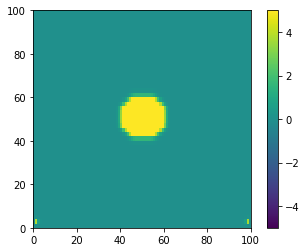

In [10]:
#Une 4 iteration
simulator.step()
u1 = simulator.download()
domain_extent = [0, nx*dx, 0, ny*dy]
im = plt.imshow(u1, origin='bottom', interpolation='none', vmin=-5, vmax=5, extent=domain_extent)
plt.colorbar()

In [11]:
print(np.max(u1))
print(np.min(u1))

10.0
0.0


In [ ]:
fig = plt.figure(figsize=(12, 8))

use_3d = False

if (use_3d):
    ax = fig.add_subplot(111, projection='3d') ###
    X, Y = np.linspace(0, nx*dx, nx), np.linspace(0, ny*dy, ny)
    X, Y = np.meshgrid(X, Y)
    surf = ax.plot_surface(X, Y, u0, cmap=cm.coolwarm, linewidth=0, antialiased=True, vmin=-5, vmax=5)
    ax.set_zlim(-5, 10)
else:
    domain_extent = [0, nx*dx, 0, ny*dy]
    im = plt.imshow(u0, origin='bottom', interpolation='none', vmin=-5, vmax=5, extent=domain_extent)
    plt.colorbar()

def animate(i):
    print(".", end='', flush=True)
    if (i > 0):
        for k in range(10):
            simulator.step()
    
    u1 = simulator.download()
    
    if (use_3d):
        ax.clear()
        surf = ax.plot_surface(X, Y, u1, cmap=cm.coolwarm, linewidth=0, antialiased=True, vmin=-5, vmax=5)
        ax.set_zlim(-5, 10)
    else:
        im.set_data(u1)
    
    

plt.rcParams["animation.html"] = "html5"
anim = animation.FuncAnimation(fig, animate, range(50), interval=100)
plt.close()
anim